In [1]:
import django, os, sys, time, resource, re, gc, shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from django.db.models import Count, Avg, F, Sum
import math

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from utils.utils import *


In [2]:
alldocs = Doc.objects.filter(
    query__project=2,
    query__qtype='MN',
    query__upload_link__category__project=2,
    query__upload_link__category__gt=0,
    wosarticle__ti__isnull=False
)

print(alldocs.count())

for d in alldocs:
    d.uploaded=True
    d.save()

pdoc_ids = Doc.objects.filter(query__project=2,uploaded=False).values_list('id',flat=True)

pdocs = Doc.objects.filter(id__in=list(set(list(pdoc_ids))))

print(pdocs.count())

423
97356


In [5]:
found = 0
for d in alldocs:
    ti = d.wosarticle.ti.replace('\r','').replace('\n','').strip()
    print(repr(ti))
    sdocs = pdocs.filter(
        title=ti
    ).exclude(id=d.id)
    if sdocs.count() == 1:
        rdoc = sdocs.first()
        for q in d.query.all():
            rdoc.query.add(q)
            
        if hasattr(d,'docfile'):
            df = d.docfile
            df.doc = rdoc
            df.save()
        rdoc.save()
        d.delete()  
        print("attached to {}".format(rdoc.UT) )
        
print("FOUND {} docs in database".format(found))

'Sustainable  biochar  to  mitigate  global climate  change'
'Atmospheric CO2 capture by algae: Negative carbon dioxide emission path'
'COP21: The algae opportunity?'
'Carbon capture and storage, bio-energy with carbon capture and storage, and theescape from the fossil-fuel lock-in'
'The economic potential of bioenergy for climate change mitigation with special attention given to implications for the land system'
'Afforestation to mitigate climate change: impacts on food prices under consideration of albedo effects'
'Trade-offs between land and water requirements for large-scale bioenergy production'
'Land-use transition for bioenergy and climate stabilization:model comparison of drivers, impacts and interactionswith other land use based mitigation options'
'Additional CO2 emissions from land use change — Forest conservation as aprecondition for sustainable production of second generation bioenergy'
'Biojet fuels and emissions mitigation in aviation: An integratedassessment modeling an

In [10]:
t.name

'NETs - General'

In [13]:
p = Project.objects.get(pk=2)
for t in Technology.objects.filter(project=2):
    new_docs = alldocs.filter(
        wos=False,
        scopus=False,
        query__upload_link__category=t
    ) | alldocs.filter(
        wos=False,
        scopus=False,
        technology=t
    )
    new_docs = new_docs.distinct()
    q = Query(
        project=p,
        title="New documents uploaded by users, with user tech tags: {}".format(t.name),
        text="[Auto generated]",
        r_count=new_docs.count(),
        creator=User.objects.get(username="galm"),
        technology=t
    )
    print(new_docs.count())
    q.save()
    tag = Tag(
        title="all",
        query=q
    )
    tag.save()
    for d in new_docs:
        d.query.add(q)
        d.tag.add(tag)
        d.save()
    print(t)

48
NETs - General
39
BECCS
10
Ocean Alkalinisation
31
Bioenergy
48
Afforestation/reforestation
3
Ethics & Morals
27
Biochar
50
Direct Air Capture
73
Ocean fertilisation
76
Soil Carbon Sequestration
8
Geological Storage
8
Enhanced Weathering
4
Blue Carbon


In [55]:
ems = EmailTokens.objects.filter(sent=True,category__gt=0,category__project=2)


for em in ems.iterator():
    em.valid_docs = Doc.objects.filter(query__upload_link=em,wosarticle__ti__isnull=False).distinct().count()
    em.save()
    
    


df = pd.DataFrame.from_dict(list(ems.values()))



df.head()

,AU,category_id,clicked,docset,email,id,project_id,sent,sent_other_project,sent_other_tech,user_id,valid_docs
0,"Keller, DP",7,3,"Keller, DP, Feng, EY, Oschlies, A (2014) Poten...",dkeller@geomar.de,ee93ace0-1c25-426c-9dbf-4a9031a5884d,NaN,True,False,False,None,1
1,"Jackson, GA",7,0,"Jackson, GA, Waite, AM, Boyd, PW (2005) Role o...",gjackson@tamu.edu,9684507d-c860-41a5-a032-2bf48cb39e15,NaN,True,False,False,None,0
2,"Oschlies, A",7,0,"Oschlies, A, Pahlow, M, Yool, A, Matear, RJ (2...",aoschlies@ifm-geomar.de,24a652cc-3b1f-4115-beeb-9b7daf58eb48,NaN,True,False,False,None,0
3,"Hale, B",7,0,"Hale, B, Dilling, L (2011) Geoengineering, Oce...",bhale@colorado.edu,92d98c26-07c0-4836-9f7d-295328e402ee,NaN,True,False,False,None,0
4,"Cusack, DF",7,0,"Cusack, DF, Axsen, J, Shwom, R, Hartzell-Nicho...",dcusack@geog.ucla.edu,103a3066-5da2-40d4-8e4b-63775b0756d3,NaN,True,False,False,None,0


In [56]:


em_bycat = ems.values('category__name').annotate(
    a_emails_sent = Count('id'),
    #b_clicks_received = Sum('clicked'),
    #c_docs_added = Sum('valid_docs'),
    #c = Subquery(query__doc.filter(wosarticle__ti__isnull=False))
    b_clicks_received = Sum(
        models.Case(
            models.When(clicked__gt=0, then=1),
            default=0, output_field=models.IntegerField()
        )
    ),
    c_docs_added = models.Sum(
        models.Case(
            models.When(query__doc__wosarticle__ti__isnull=False, then=1),
            default=0, output_field=models.IntegerField()
        )
    )
)

bc = pd.DataFrame.from_dict(list(em_bycat))

bc.head(15)



,a_emails_sent,b_clicks_received,c_docs_added,category__name
0,103,51,33,NETs - General
1,3,0,0,Ethics & Morals
2,31,10,6,Geological Storage
3,129,16,34,BECCS
4,76,22,13,Biochar
5,335,130,81,Soil Carbon Sequestration
6,5,3,1,Ocean Alkalinisation
7,167,76,56,DACCS
8,251,139,121,Ocean fertilisation
9,32,12,9,Bioenergy


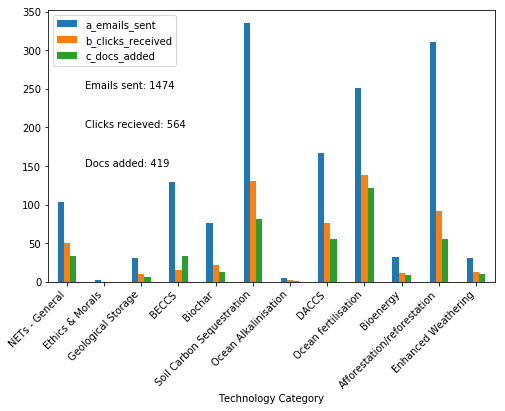

In [57]:
plt.rcParams["figure.figsize"] = [8,5]


pdf = bc.set_index('category__name')

pdf.plot.bar()

plt.text(0.5,250,"Emails sent: {}".format(pdf['a_emails_sent'].sum()))
plt.text(0.5,200,"Clicks recieved: {}".format(pdf['b_clicks_received'].sum()))
plt.text(0.5,150,"Docs added: {}".format(pdf['c_docs_added'].sum()))
#plt.text(0.5,700,"Docs added: {}".format(pdf['c_unique_clicks'].sum()))

plt.xlabel('Technology Category')

ls = ["Emails sent", "Clicks received", "Docs added"]

#for i,t in enumerate(plt.legend().get_texts()):
    #t.set_text(ls[i])
    
plt.xticks(rotation=45,ha="right")
plt.savefig('../plots/general/emails_responses.pdf',bbox_inches='tight') 
plt.savefig('../plots/general/emails_responses.png',bbox_inches='tight') 
plt.show()

In [3]:
newqs = Query.objects.filter(id__gt=2286,id__lt=2300,project=2,creator__username="galm")

newdocs = Doc.objects.filter(query__in=newqs)

print(newdocs.distinct().count())

273


In [44]:
doc_ids = []
rated_docs = []
unrated_docs = []
all_docs = []
p_docs = []
n_docs = []
for q in newqs:
    print(q.title)
    qdocs = Doc.objects.filter(query=q)
    all_docs.append(list(qdocs.values_list('id',flat=True)))
    print("Documents Added: {}".format(qdocs.count()))
    # Any ratings
    ratings = DocOwnership.objects.filter(query=q,relevant__gt=0)
    print(ratings.count())
    rdocs = qdocs.filter(id__in=list(set(ratings.values_list('doc__id',flat=True))))
    rated_docs.append(list(set(list(rdocs.values_list('id',flat=True)))))
    
    # Negative ratings
    nrs = DocOwnership.objects.filter(query=q,relevant=2)
    n_docs.append(list(set(list(qdocs.filter(
        id__in=list(set(nrs.values_list('doc__id',flat=True)))
    ).values_list('id',flat=True)))))
    
    # Positive ratings
    prs = DocOwnership.objects.filter(query=q,relevant=1)
    pdocs = qdocs.filter(id__in=list(set(prs.values_list('doc__id',flat=True))))
    p_docs.append(list(set(list(pdocs.values_list('id',flat=True)))))
    
    print("Documents Relevant: {}".format(pdocs.count()))
    
    # Unrated docs
    ur_docs = qdocs.exclude(id__in=list(set(ratings.values_list('doc__id',flat=True))))
    unrated_docs.append(list(set(list(ur_docs.values_list('id',flat=True)))))
    
    # All docs in the query that do not have a negative rating
    nrdocs = qdocs.exclude(id__in=list(set(nrs.values_list('doc__id',flat=True))))
    nids = set(list(nrdocs.values_list('id',flat=True)))
    print(len(nids))
    doc_ids.append(list(nids))

print("Total Docs: {}".format(len(list(set(flatten(all_docs))))))
print("Unrated_docs: {}".format(len(list(set(flatten(unrated_docs))))))
print("Potentially relevant (unrated or relevant) Docs: {}".format(len(list(set(flatten(doc_ids))))))
print("Documents rated: {}".format(len(list(set(flatten(rated_docs))))))
print("Documents rated relevant: {}".format(len(list(set(flatten(p_docs))))))
print("Documents rated irrelevant: {}".format(len(list(set(flatten(n_docs))))))

New documents uploaded by users, with user tech tags: Enhanced Weathering
Documents Added: 8
8
Documents Relevant: 2
2
New documents uploaded by users, with user tech tags: Blue Carbon
Documents Added: 4
0
Documents Relevant: 0
4
New documents uploaded by users, with user tech tags: Direct Air Capture
Documents Added: 50
50
Documents Relevant: 28
28
New documents uploaded by users, with user tech tags: Ocean fertilisation
Documents Added: 59
70
Documents Relevant: 20
23
New documents uploaded by users, with user tech tags: Geological Storage
Documents Added: 8
8
Documents Relevant: 8
8
New documents uploaded by users, with user tech tags: Soil Carbon Sequestration
Documents Added: 76
76
Documents Relevant: 14
14
New documents uploaded by users, with user tech tags: Afforestation/reforestation
Documents Added: 48
48
Documents Relevant: 11
11
New documents uploaded by users, with user tech tags: Ethics & Morals
Documents Added: 3
3
Documents Relevant: 1
1
New documents uploaded by users,

In [28]:
relevant = Doc.objects.filter(id__in=set(flatten(p_docs)))
relevant.count()
p = Project.objects.get(pk=2)
oqs = Query.objects.filter(pk__in=[2359,2366])
oqdocs = Doc.objects.filter(query__in=oqs)

q, created = Query.objects.get_or_create(
    project=p,
    title="Relevant new docs_3",
    text="[Auto generated]",
    creator=User.objects.get(username="galm") 
)
q.save()
for r in relevant:
    if r.id not in list(oqdocs.values_list('id',flat=True)):
        r.query.add(q)
        
q.r_count = q.doc_set.count()
print(q.r_count)
q.save()
#q.delete()

17


In [41]:
relevant = Doc.objects.filter(id__in=set(flatten(p_docs)))
relevant.count()

nq = "TI=({})".format(' OR '.join(['"{}"'.format(x.title) for x in relevant]))

print(nq)

TI=("Implications of large-scale iron fertilization of the oceans - Introduction and synthesis" OR "Biomass enables the transition to a carbon-negative power system across western North America" OR "Prospects of carbon capture and storage (CCS) in China's power sector - An integrated assessment" OR "Low efficiency of nutrient translocation for enhancing oceanic uptake of carbon dioxide" OR "Biojet fuels and emissions mitigation in aviation: An integrated assessment modeling analysis" OR "Forest transitions, trade, and the global displacement of land use" OR "Development of monolithic adsorbent via polymeric sol-gel process for low-concentration CO2 capture" OR "Physical and ecological uncertainties in the widespread implementation of controlled upwelling in the North Pacific Subtropical Gyre" OR "Global Tree Cover and Biomass Carbon on Agricultural Land: The contribution of agroforestry to global and national carbon budgets" OR "Influence of production conditions on the yield and envir

In [29]:
relevant.filter(title__icontains='\n')
ccodes = [u'\u2010',u'\u2011',u'\u2012',u'\u2013',u'\u2014']

for c in ccodes:
    for r in relevant.filter(title__icontains=c):
        print(repr(r.title))
        r.title = r.title.replace(c,'-')
        r.wosarticle.ti = r.title
        r.save()
        #r.title = r.title.replace('\n').('')
        
for r in relevant.filter(title__icontains='\n'):
    r.title = r.title.replace('\r\n',' ')
    r.title = r.title.replace('  ',' ')
    r.wosarticle.ti = r.title
    r.save()
    print(repr(r.title))
    #r.title = r.title.replace('\n',' ')
    #r.wosarticle.ti = r.title
    #r.save()
    #r.title = r.title.replace('\n').('')
    
for r in relevant.filter(title__icontains='’'):    
    r.title = r.title.replace('’',"'")
    r.wosarticle.ti = r.title
    r.save()    

In [33]:
nq = Query.objects.get(pk=2719)
nqdocs = Doc.objects.filter(query=nq)

for d in nqdocs:
    rdoc = None
    try:
        rdoc = relevant.get(title__iexact=d.title)
        #print(d.title)
        #print(rdoc.title)
    except:
        print('#')
        print(repr(d.title))
        for r in relevant:
            j = jaccard(r.shingle(), d.shingle())
            if j > 0.5:
                rdoc = r
    
                print(repr(rdoc.title))
    if rdoc:
        for q in rdoc.query.all():
            d.query.add(q)
            
        for t in rdoc.tag.all():
            d.tag.add(t)

        for do in rdoc.docownership_set.all():
            do.doc = d
            do.save()
        if hasattr(rdoc,'docfile'):
            df = rdoc.docfile
            df.doc = d
            df.save()
            #df.save()
        d.save()
        rdoc.delete()


        


#
'Ecosystem changes after the SEEDS iron fertilization in the western North Pacific simulated by a one-dimensional ecosystem model'
#
'Forest Biomass Supply in the Southeastern United States-Implications for Industrial Roundwood and Bioenergy Production'
'Forest Biomass Supply in the Southeastern United States - Implications for Industrial Roundwood and Bioenergy Production'
#
'Implications of large-scale iron fertilization of the oceans - Introduction and synthesis'
'Implications of large-scale iron fertilization of the oceans'
#
'Widespread implementation of controlled upwelling in the North Pacific Subtropical Gyre would counteract diazotrophic N-2 fixation'
'Widespread implementation of controlled upwelling in the North Pacific Subtropical Gyre would counteract diazotrophic N 2 fixation'
#
'Influence of production conditions on the yield and environmental stability of biochar'
'Influence of production conditions on the yield and environmental stability of biochar.'
#
'Reversing Ex

In [42]:
print(relevant.count())

list(relevant)


147


[<Doc: WOS:000258810800019>,
 <Doc: WOS:000350327800017>,
 <Doc: WOS:000364249200020>,
 <Doc: WOS:000269246200001>,
 <Doc: WOS:000401398400018>,
 <Doc: WOS:000285050800016>,
 <Doc: WOS:000353755000028>,
 <Doc: WOS:000261797800030>,
 <Doc: WOS:000379919600001>,
 <Doc: WOS:000311932200022>,
 <Doc: WOS:000274788200002>,
 <Doc: WOS:000255460600003>,
 <Doc: WOS:000301277000009>,
 <Doc: WOS:000374196200041>,
 <Doc: WOS:000295327900020>,
 <Doc: WOS:000315388200011>,
 <Doc: WOS:A1991HR98100031>,
 <Doc: WOS:000345702900077>,
 <Doc: WOS:000377729000017>,
 <Doc: WOS:000261797800029>,
 <Doc: WOS:000321007000016>,
 <Doc: WOS:000389576500005>,
 <Doc: WOS:000295536000019>,
 <Doc: WOS:000286577100038>,
 <Doc: WOS:000283645400007>,
 <Doc: WOS:000376459200040>,
 <Doc: WOS:000258810800029>,
 <Doc: WOS:000237646500003>,
 <Doc: WOS:000229210800004>,
 <Doc: WOS:000384851000029>,
 <Doc: WOS:000319947300006>,
 <Doc: WOS:000356462400031>,
 <Doc: WOS:000304725100026>,
 <Doc: WOS:000303571700005>,
 <Doc: WOS:000

In [138]:
relevant

i = 0
qlen = 0
for r in relevant:
    try:
        
        qs = r.query.all()
        if qs.count() > 0:
            qlen+=1
        print(r.query.all())
        i+=1
    except:
        print(r)
        pass
    
print(i)
print(qlen)

<QuerySet []>
<QuerySet []>
<QuerySet [<Query: Relevant new docs_Bioenergy_RD>, <Query: Relevant new docs_1>, <Query: New documents uploaded by users, with user tech tags: Bioenergy>, <Query: New documents uploaded by users, with user tech tags: BECCS>, <Query: New documents uploaded by users, with user tech tags: NETs - General>, <Query: New documents uploaded by users: BECCS>, <Query: New documents uploaded by users: NETs - General>, <Query: uploaded_by_Moreira, D>, <Query: uploaded_by_Pires, JCM>]>
<QuerySet []>
<QuerySet []>
<QuerySet []>
<QuerySet []>
<QuerySet []>
<QuerySet [<Query: Relevant new docs_Bioenergy_Demandpull>, <Query: Relevant new docs_Bioenergy_RD>, <Query: Relevant new docs_BECCS_Demandpull>, <Query: Relevant new docs_BECCS_RD>, <Query: Relevant new docs_1>, <Query: New documents uploaded by users, with user tech tags: Bioenergy>, <Query: New documents uploaded by users, with user tech tags: BECCS>, <Query: New documents uploaded by users: BECCS>, <Query: uploaded_

In [80]:
ems = Doc.objects.filter(title__icontains=u'\u2014')
print(ems.first().title)
print(ems.count())

ens = Doc.objects.filter(title__icontains=u'\u2013')
print(ens.first().title)
print(ens.count())

hyphens = Doc.objects.filter(title__icontains=u'\u2010')
print(hyphens.first().title)
print(hyphens.count())



dash = Doc.objects.filter(title__icontains='-')
print(dash.first().title)
print(dash.count())

Training Professional Leaders—the new school managers
305
Principles of south–south cooperation and emerging evidence from Indian engagements
983
SENSITWITY OF IRRIGATION DEMAND IN A HUMID‐TEMPERATE REGION TO HYPOTHETICAL CLIMATIC CHANGE
244
Proof of concept for a new energy-positive wastewater treatment scheme
265392


In [65]:
relevant.get(title__icontains="Prospects of carbon capture and storage (CCS) in India's power sector –")
relevant.get(title__icontains="Prospects of carbon capture and storage (CCS) in India's power sector -")

DoesNotExist: Doc matching query does not exist.

In [79]:
u'-'.encode('raw_unicode_escape')

b'-'

In [6]:
doc_ids = []
rated_docs = []
for q in newqs:
    print(q.technology.name)
    qdocs = Doc.objects.filter(query=q)
    print("{} documents".format(qdocs.count()))
    # Any ratings
    ratings = DocOwnership.objects.filter(query=q,relevant__gt=0)
    #print(ratings.count())
    rdocs = qdocs.filter(id__in=list(set(ratings.values_list('doc__id',flat=True))))
    rdoc_ids = set(ratings.values_list('doc__id',flat=True))
    
    print("{} rated".format(len(rdoc_ids)))
    
    dos = DocOwnership.objects.filter(query=q)
    users = User.objects.filter(docownership__in=dos).distinct()
    users = ', '.join([u.username + " " + u.email for u in users])

    print("Users: {}\n".format(users))
    


NETs - General
48 documents
48 rated
Users: minj minx@mcc-berlin.net, galm callaghan@mcc-berlin.net

BECCS
39 documents
39 rated
Users: minj minx@mcc-berlin.net, delm mariaz09@gmail.com

Ocean Alkalinisation
10 documents
10 rated
Users: atho thorben.amann@uni-hamburg.de, garw wagner.oliveira.garcia@uni-hamburg.de

Bioenergy
31 documents
31 rated
Users: minj minx@mcc-berlin.net, delm mariaz09@gmail.com

Afforestation/reforestation
48 documents
48 rated
Users: lamw lamw@mcc-berlin.net, fuss fuss@mcc-berlin.net

Ethics & Morals
3 documents
0 rated
Users: lend 

Biochar
27 documents
27 rated
Users: vicl VicenteVicente@mcc-berlin.net

Direct Air Capture
50 documents
0 rated
Users: cref creutzig@mcc-berlin.net

Ocean fertilisation
62 documents
73 rated
Users: atho thorben.amann@uni-hamburg.de, garw wagner.oliveira.garcia@uni-hamburg.de

Soil Carbon Sequestration
76 documents
76 rated
Users: khat tarun.kh@gmail.com, smip pete.smith@abdn.ac.uk

Geological Storage
8 documents
8 rated
Users: min

In [48]:
dos = DocOwnership.objects.filter(query__in=newqs,relevant=2)
print(dos.count())
dos.values()

137


<QuerySet [{'date': datetime.datetime(2018, 2, 8, 13, 25, 1, 757458, tzinfo=<UTC>), 'query_id': 2287, 'id': 42117, 'user_id': 1, 'tag_id': 529, 'relevant': 2, 'doc_id': 757687}, {'date': datetime.datetime(2018, 2, 8, 13, 24, 9, 558550, tzinfo=<UTC>), 'query_id': 2287, 'id': 42113, 'user_id': 1, 'tag_id': 529, 'relevant': 2, 'doc_id': 761334}, {'date': datetime.datetime(2018, 2, 8, 13, 22, 54, 31791, tzinfo=<UTC>), 'query_id': 2287, 'id': 42109, 'user_id': 1, 'tag_id': 529, 'relevant': 2, 'doc_id': 757705}, {'date': datetime.datetime(2018, 2, 8, 13, 19, 44, 876179, tzinfo=<UTC>), 'query_id': 2287, 'id': 42103, 'user_id': 1, 'tag_id': 529, 'relevant': 2, 'doc_id': 757789}, {'date': datetime.datetime(2018, 2, 8, 13, 19, 32, 645295, tzinfo=<UTC>), 'query_id': 2287, 'id': 42101, 'user_id': 1, 'tag_id': 529, 'relevant': 2, 'doc_id': 761335}, {'date': datetime.datetime(2018, 2, 8, 13, 19, 6, 970869, tzinfo=<UTC>), 'query_id': 2287, 'id': 42099, 'user_id': 1, 'tag_id': 529, 'relevant': 2, 'doc